# Training a logistic regression classifier on MNIST under a norm constraint.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cooper-org/cooper/blob/master/docs/source/notebooks/plot_mnist_logistic_regression.ipynb)


:::{note}
This example illustrates how to use **Cooper** on a simple machine learning problem
that involves using mini-batches of data.
:::

In this example, we consider a simple convex constrained optimization problem: training
a Logistic Regression classifier on the MNIST dataset. The model is constrained so that
the squared L2 norm of its parameters is less than 1.

Although we employ a simple Logistic Regression model, the same principles can be applied

This example illustrates how **Cooper** integrates with a typical PyTorch training
pipeline, where:
- models are defined using a ``torch.nn.Module``,
- steps loop over mini-batches of data,
- CUDA acceleration is used.

In [3]:
%%capture
# %pip install cooper-optim
%pip install --index-url https://test.pypi.org/simple/ --no-deps cooper-optim  # TODO: Remove this line when cooper deployed to pypi

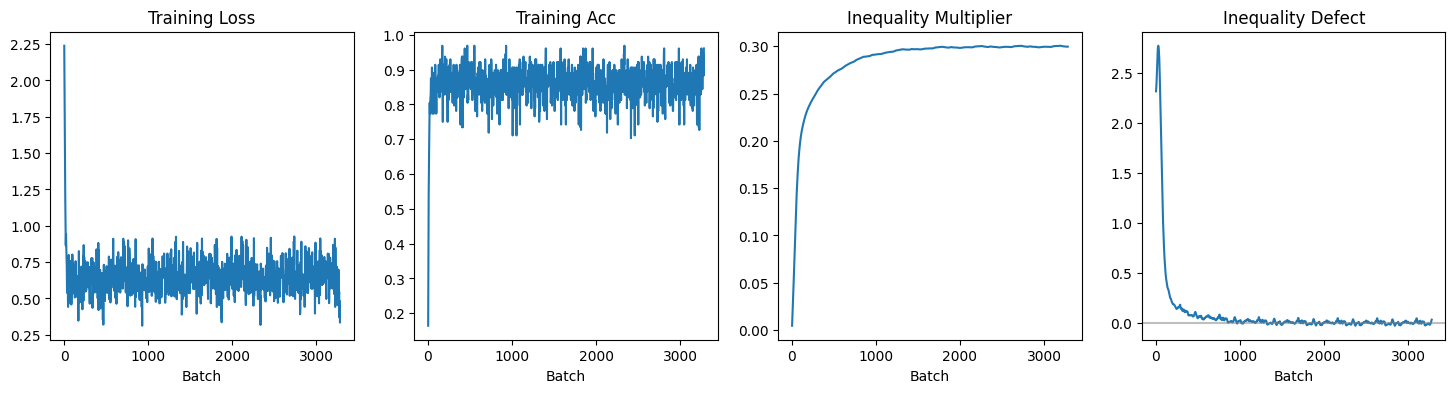

In [4]:
import os
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms

import cooper

np.random.seed(0)
torch.manual_seed(0)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class NormConstrainedLogisticRegression(cooper.ConstrainedMinimizationProblem):
    def __init__(self, constraint_level: float = 1.0):
        super().__init__()

        self.constraint_level = constraint_level

        # The multiplier must be on the same device as the model
        multiplier = cooper.multipliers.DenseMultiplier(num_constraints=1, device=DEVICE)

        self.norm_constraint = cooper.Constraint(
            constraint_type=cooper.ConstraintType.INEQUALITY,
            formulation_type=cooper.LagrangianFormulation,
            multiplier=multiplier,
        )

    def compute_cmp_state(self, model: torch.nn.Module, inputs: torch.Tensor, targets: torch.Tensor) -> cooper.CMPState:
        logits = model(inputs.view(inputs.shape[0], -1))
        loss = torch.nn.functional.cross_entropy(logits, targets)
        accuracy = (logits.argmax(dim=1) == targets).float().mean()

        sq_l2_norm = model.weight.pow(2).sum() + model.bias.pow(2).sum()

        # Constraint violations use convention g <= 0
        constraint_state = cooper.ConstraintState(violation=sq_l2_norm - self.constraint_level)

        # Create a CMPState object, which contains the loss and observed constraints
        observed_constraints = {self.norm_constraint: constraint_state}
        return cooper.CMPState(loss=loss, observed_constraints=observed_constraints, misc={"accuracy": accuracy})


# Load the MNIST dataset
data_path = "./data"
data_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
dataset = datasets.MNIST(data_path, train=True, download=True, transform=data_transforms)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=128, num_workers=2, pin_memory=torch.cuda.is_available())

# Create a Logistic Regression model
model = torch.nn.Linear(in_features=28 * 28, out_features=10, bias=True)
model = model.to(DEVICE)

# Instantiate the constrained optimization problem
cmp = NormConstrainedLogisticRegression(constraint_level=1.0)

# Instantiate a PyTorch optimizer for the primal variables
primal_optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, amsgrad=True)

# Instantiate PyTorch optimizer for the dual variables
dual_optimizer = torch.optim.SGD(cmp.dual_parameters(), lr=1e-3, maximize=True)

# Instantiate the Cooper optimizer
cooper_optimizer = cooper.optim.SimultaneousOptimizer(
    primal_optimizers=primal_optimizer, dual_optimizers=dual_optimizer, cmp=cmp
)

# Create a directory to save checkpoints
checkpoint_path = "./checkpoint"
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

# Load checkpoint if exists
if not os.path.isfile(checkpoint_path + "/checkpoint.pth"):
    batch_ix = 0
    start_epoch = 0
    all_metrics = defaultdict(list)
else:
    checkpoint = torch.load(checkpoint_path + "/checkpoint.pth", weights_only=True)
    batch_ix = checkpoint["batch_ix"]
    start_epoch = checkpoint["epoch"] + 1
    all_metrics = checkpoint["all_metrics"]
    model.load_state_dict(checkpoint["model_state_dict"])
    cmp.load_state_dict(checkpoint["cmp_state_dict"])
    cooper_optimizer.load_state_dict(checkpoint["cooper_optimizer_state_dict"])

for epoch_num in range(start_epoch, 7):
    for inputs, targets in train_loader:
        batch_ix += 1

        if torch.cuda.is_available():
            inputs, targets = inputs.cuda(non_blocking=True), targets.cuda(non_blocking=True)

        _, cmp_state, primal_lagrangian_store, _ = cooper_optimizer.roll(
            compute_cmp_state_kwargs={"model": model, "inputs": inputs, "targets": targets}
        )

        if batch_ix % 3 == 0:
            all_metrics["batch_ix"].append(batch_ix)
            all_metrics["train_loss"].append(cmp_state.loss.item())
            all_metrics["train_acc"].append(cmp_state.misc["accuracy"].item())

            multiplier_value = primal_lagrangian_store.multiplier_values[cmp.norm_constraint].item()
            all_metrics["multiplier_value"].append(multiplier_value)

            constraint_violation = cmp_state.observed_constraints[cmp.norm_constraint].violation
            all_metrics["constraint_violation"].append(constraint_violation.item())

    # Save checkpoint at the end of each epoch
    torch.save(
        {
            "batch_ix": batch_ix,
            "epoch": epoch_num,
            "all_metrics": all_metrics,
            "model_state_dict": model.state_dict(),
            "cmp_state_dict": cmp.state_dict(),
            "cooper_optimizer_state_dict": cooper_optimizer.state_dict(),
        },
        checkpoint_path + "/checkpoint.pth",
    )

del batch_ix, all_metrics, model, cmp, cooper_optimizer

# Post-training analysis and plotting
all_metrics = torch.load(checkpoint_path + "/checkpoint.pth", weights_only=True)["all_metrics"]

fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, sharex=True, figsize=(18, 4))

ax0.plot(all_metrics["batch_ix"], all_metrics["train_loss"])
ax0.set_xlabel("Batch")
ax0.set_title("Training Loss")

ax1.plot(all_metrics["batch_ix"], all_metrics["train_acc"])
ax1.set_xlabel("Batch")
ax1.set_title("Training Acc")

ax2.plot(all_metrics["batch_ix"], np.stack(all_metrics["multiplier_value"]))
ax2.set_xlabel("Batch")
ax2.set_title("Inequality Multiplier")

ax3.plot(all_metrics["batch_ix"], np.stack(all_metrics["constraint_violation"]))
# Show that defect converges close to zero
ax3.axhline(0.0, c="gray", alpha=0.5)
ax3.set_xlabel("Batch")
ax3.set_title("Inequality Defect")

plt.show()